In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence-transformers scikit-multilearn joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [3]:
stop_words = set('''sooner
on
for
this
and
some
soon
ago
said
me
are
is
please
to
in
any
only
we
am
was
by
the
it
has
is
most
hes
shes
its
were
theyre
ive
weve
theyve
hed
shed
we'd
they'd
i'll
he'll
she'll
we'll
they'll
through
lets
do
be
an
such
of
tends
thats
therein
theyre
those
from
did
or
us
that
your
very
in
so
much
too
really
i
sir
yourself
would
many
have
you
a'''.split())

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import pandas as pd
import tensorflow as tf


from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re


from nltk import download
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, SpatialDropout1D, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score
import joblib

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Intent Classification/LSTM_Intent/Dataset/training_intent_t-d5e6bbf5-34f5-4332-9a3f-33fba8dd4223_mywork_6.en.csv")

In [ ]:
dataset["Text"]

0       i am not able to see my direct reportees
1               I cannot see my direct reportees
2                 I cant see my direct reportees
3      my direct reportees are not visible to me
4             I can not view my direct reportees
                         ...                    
687                          are you alright sir
688                             how was your day
689                   I want to know how are you
690               so can you tell me how are you
691                       may I know how are you
Name: Text, Length: 692, dtype: object

In [ ]:
Intent_counts = dataset["Intents"].value_counts()

In [ ]:
Intent_counts

Intents
bot_greets_good_morning                                                          69
can_i_apply_for_leaves                                                           65
bot_greets_hello                                                                 53
bot_greets_how_are_you                                                           43
can_i_submit_my_timesheet                                                        31
bot_responds_to_goodbye                                                          27
bot_greets_good_evening                                                          25
can_i_edit_the_timesheet_post_submission                                         24
bot_greets_thank_you                                                             22
not_showing_in_my_work_application                                               22
bot_greets_good_night                                                            21
bot_greets_good_afternoon                                           

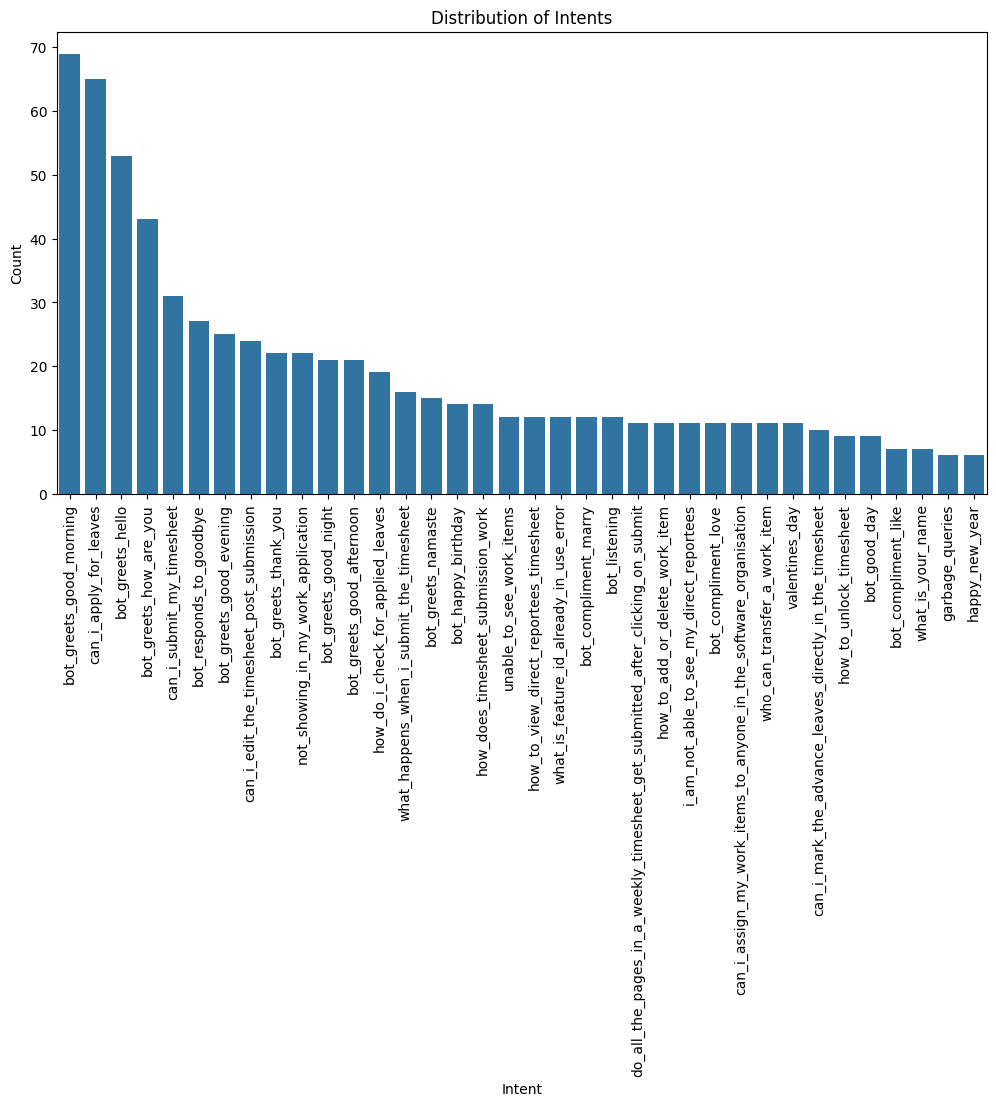

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=Intent_counts.index, y=Intent_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of Intents')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

In [6]:
lemmatizer=WordNetLemmatizer()

def preprocess_text(text):
  """
  This function cleans and preprocesses text data.

  Args:
      text: The text string to be preprocessed.

  Returns:
      The preprocessed text string.
  """

  text = re.sub('<.*?>', ' ', text)  # removal of html characters
  text = re.sub('[^a-zA-Z0-9]', ' ', text)
  text = text.lower().strip()  # Lowercase and remove leading/trailing whitespace
  text = re.sub(r"[^\w\s]", " ", text)  # Replace non-alphanumeric characters with spaces
  text = re.sub(r"\s+", " ", text)
  text = re.sub("\n", " ", text)  # remove new lines
  text = re.sub("\s\s+", " ", text)  # remove consecutive white spaces
  tokens = word_tokenize(text)  # Tokenize
  filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
  lst = []
  for word in filtered_tokens:
    lst.append(lemmatizer.lemmatize(word))
  cleaned_text = ' '.join(lst)
  return cleaned_text

In [7]:
sentences_cleaned = dataset['Text'].apply(lambda x: preprocess_text(str(x)))

In [ ]:
sentences_cleaned

0      not able see my direct reportees
1       can not see my direct reportees
2          cant see my direct reportees
3       my direct reportees not visible
4      can not view my direct reportees
                     ...               
687                             alright
688                             how day
689                       want know how
690                        can tell how
691                        may know how
Name: Text, Length: 692, dtype: object

In [ ]:
sentences_cleaned.isna().all()

False

In [8]:
sentences_cleaned.name = 'sentences_cleaned'

## TFIDF approach

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [ ]:
X = tfidf_vectorizer.fit_transform(sentences_cleaned)

## Sentence Transformers Approach


In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
X = sentences_cleaned

In [ ]:
sentence_vectors = model.encode(X.tolist(), show_progress_bar = True)

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
X = sentence_vectors

## Label Encoding

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['Intents'])

In [ ]:
y

array([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 22, 22, 22, 22, 22, 22,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27,  3,  3,  3,  3,  3,  3,  3,  3,  3, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 30, 30, 30

In [ ]:
X.shape

(692, 428)

## Tokenizer approach for NN Models

In [9]:
df = pd.concat([dataset, sentences_cleaned], axis=1)

In [10]:
df.drop(columns=['Text'], inplace=True)

In [11]:
df = df[df['sentences_cleaned'] != '']

In [12]:
df

,Intents,sentences_cleaned
0,i_am_not_able_to_see_my_direct_reportees,not able see my direct reportees
1,i_am_not_able_to_see_my_direct_reportees,can not see my direct reportees
2,i_am_not_able_to_see_my_direct_reportees,cant see my direct reportees
3,i_am_not_able_to_see_my_direct_reportees,my direct reportees not visible
4,i_am_not_able_to_see_my_direct_reportees,can not view my direct reportees
...,...,...
687,bot_greets_how_are_you,alright
688,bot_greets_how_are_you,how day
689,bot_greets_how_are_you,want know how
690,bot_greets_how_are_you,can tell how


In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df["sentences_cleaned"].values)

In [14]:
X = tokenizer.texts_to_sequences(df["sentences_cleaned"].values)

In [15]:
X = pad_sequences(X, maxlen = 50)

In [16]:
X

array([[  0,   0,   0, ...,   1,  34,  20],
       [  0,   0,   0, ...,   1,  34,  20],
       [  0,   0,   0, ...,   1,  34,  20],
       ...,
       [  0,   0,   0, ...,  13,  32,   5],
       [  0,   0,   0, ...,   4,  27,   5],
       [  0,   0,   0, ..., 106,  32,   5]], dtype=int32)

## One-Hot Encoding for NN Models

In [17]:
label_mapping = {i: label for i, label in enumerate (df['Intents']. unique())}
# Reverse label mapping for interpretation
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Encode labels using the reverse label mapping
encoded_labels = df['Intents'].map(reverse_label_mapping)
# Assuming Y contains labels
y = pd.get_dummies (encoded_labels).values

In [18]:
y.shape

(692, 36)

## Train-Test Split


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Plotting Function

In [26]:
def plot_training_validation_curves(history, figsize=(12, 6)):
    """
    Plots the training and validation loss and accuracy curves for a Keras model.

    Parameters:
    history (dict): The history object returned by the fit() method of a Keras model.
    figsize (tuple): The size of the figure in inches (width, height).
    """
    # Convert the history object to a pandas DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot the loss curves
    ax1.plot(history_df['loss'], label='Training Loss')
    ax1.plot(history_df['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the accuracy curves
    ax2.plot(history_df['accuracy'], label='Training Accuracy')
    ax2.plot(history_df['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Show the plot
    plt.show()

## Baseline Models with TFIDF-Vectorizer


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Linear SVM': LinearSVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Multi-layer Perceptron': MLPClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

for model_name, model_type in models.items():
    model_type.fit(X_train, y_train)

    y_pred = model_type.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Results:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Results:
Accuracy: 0.8273381294964028
Precision: 0.803151068888479
Recall: 0.8273381294964028
F1-Score: 0.7942270445141634



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

Random Forest Results:
Accuracy: 0.9136690647482014
Precision: 0.9179916570944925
Recall: 0.9136690647482014
F1-Score: 0.9076612118803892

Linear SVM Results:
Accuracy: 0.8992805755395683
Precision: 0.9055327166837959
Recall: 0.8992805755395683
F1-Score: 0.8934772279470434

Naive Bayes Results:
Accuracy: 0.6115107913669064
Precision: 0.5403632578833595
Recall: 0.6115107913669064
F1-Score: 0.5269778717589729



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Gradient Boosting Results:
Accuracy: 0.7841726618705036
Precision: 0.798438172538892
Recall: 0.7841726618705036
F1-Score: 0.755921237036345

Decision Tree Results:
Accuracy: 0.8345323741007195
Precision: 0.8706552405134717
Recall: 0.8345323741007195
F1-Score: 0.8318555515625943



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multi-layer Perceptron Results:
Accuracy: 0.8776978417266187
Precision: 0.8672203413739598
Recall: 0.8776978417266187
F1-Score: 0.8651584747239802



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoost Results:
Accuracy: 0.20863309352517986
Precision: 0.13079372567519754
Recall: 0.20863309352517986
F1-Score: 0.13776441533340492

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 23
[LightGBM] [Info] Start training from score -4.369448
[LightGBM] [Info] Start training from score -4.523599
[LightGBM] [Info] Start training from score -3.830451
[LightGBM] [Info] Start training from score -4.523599
[LightGBM] [Info] Start training from score -3.370919
[LightGBM] [Info] Start training from score -3.319626
[LightGBM] [Info] Start training from score -2.326374
[LightGBM] [Info] Start training from score -3.424986
[LightGBM] [Info] Start training from score -2.651796
[LightGBM] [Info] Start tr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results for Baseline Models using TFIDF
### Logistic Regression: 82.73% accuracy
### Random Forest: 91.36% accuracy
### Linear SVM: 89.92% accuracy
### Naive Bayes: 61.15% accuracy
### Gradient Bossting: 78.41% accuracy
### Decision Tree: 83.45% accuracy
### MLP: 87.76% accuracy
### AdaBoost: 20.86% accuracy
### LightGBM: 66.90% accuracy


## Baseline model using sentence transformers

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Linear SVM': LinearSVC(random_state=42),
    #'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(loss='log_loss',
                                 n_estimators=500,
                                 learning_rate=0.1,
                                 random_state=100,
                                 max_features='sqrt',
                                 max_depth=1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Multi-layer Perceptron': MLPClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

for model_name, model_type in models.items():
    model_type.fit(X_train, y_train)

    y_pred = model_type.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Results:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Results:
Accuracy: 0.935251798561151
Precision: 0.9586330935251799
Recall: 0.935251798561151
F1-Score: 0.9372313369662859



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Results:
Accuracy: 0.9136690647482014
Precision: 0.9363820132705025
Recall: 0.9136690647482014
F1-Score: 0.9101377331314673



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Linear SVM Results:
Accuracy: 0.9064748201438849
Precision: 0.9331680873788365
Recall: 0.9064748201438849
F1-Score: 0.9056406487713056



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gradient Boosting Results:
Accuracy: 0.8705035971223022
Precision: 0.8866906474820144
Recall: 0.8705035971223022
F1-Score: 0.8583942594433657



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Results:
Accuracy: 0.6618705035971223
Precision: 0.7414182939362794
Recall: 0.6618705035971223
F1-Score: 0.6760052518477357



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multi-layer Perceptron Results:
Accuracy: 0.9280575539568345
Precision: 0.944977863862756
Recall: 0.9280575539568345
F1-Score: 0.9265654544033946



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoost Results:
Accuracy: 0.18705035971223022
Precision: 0.15034211163179548
Recall: 0.18705035971223022
F1-Score: 0.12244059027535473

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70904
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 384
[LightGBM] [Info] Start training from score -4.369448
[LightGBM] [Info] Start training from score -4.523599
[LightGBM] [Info] Start training from score -3.830451
[LightGBM] [Info] Start training from score -4.523599
[LightGBM] [Info] Start training from score -3.370919
[LightGBM] [Info] Start training from score -3.319626
[LightGBM] [Info] Start training from score -2.326374
[LightGBM] [Info] Start training from score -3.424986
[LightGBM] [Info] Start training from score -2.651796
[LightGBM] [Info] Start training from score -2.788997
[LightGBM] [Info] Start training 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results for Baseline Models using Sentence Transformer
### Logistic Regression: 93.52% accuracy
### Random Forest: 91.36% accuracy
### Linear SVM: 90.64% accuracy
### Gradient Bossting: 87.05% accuracy
### Decision Tree: 66.18% accuracy
### MLP: 92.80% accuracy
### AdaBoost: 18.70% accuracy
### LightGBM: 89.92% accuracy



In [29]:
model_RNN = Sequential()
model_RNN.add(Embedding(500, 100, input_length=X.shape[1]))
model_RNN.add(SpatialDropout1D(0.2))
model_RNN.add(SimpleRNN(64, dropout = 0.2, recurrent_dropout=0.2))
model_RNN.add(Dense(36, activation='softmax'))

model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d_2 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_2 (Dense)             (None, 36)                2340      
                                                                 
Total params: 62900 (245.70 KB)
Trainable params: 62900 (245.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history_RNN = model_RNN.fit(X_train, y_train, validation_split = 0.1, epochs=50, batch_size = 64)

Epoch 1/50
8/8 [==============================] - 3s 101ms/step - loss: 3.6213 - accuracy: 0.0302 - val_loss: 3.5467 - val_accuracy: 0.0536
Epoch 2/50
8/8 [==============================] - 0s 37ms/step - loss: 3.5781 - accuracy: 0.0584 - val_loss: 3.4900 - val_accuracy: 0.1071
Epoch 3/50
8/8 [==============================] - 0s 37ms/step - loss: 3.5082 - accuracy: 0.0845 - val_loss: 3.4331 - val_accuracy: 0.1250
Epoch 4/50
8/8 [==============================] - 0s 62ms/step - loss: 3.4331 - accuracy: 0.0865 - val_loss: 3.3437 - val_accuracy: 0.3393
Epoch 5/50
8/8 [==============================] - 0s 61ms/step - loss: 3.3428 - accuracy: 0.1388 - val_loss: 3.2563 - val_accuracy: 0.3929
Epoch 6/50
8/8 [==============================] - 1s 65ms/step - loss: 3.2498 - accuracy: 0.1851 - val_loss: 3.1611 - val_accuracy: 0.3929
Epoch 7/50
8/8 [==============================] - 0s 61ms/step - loss: 3.1829 - accuracy: 0.2233 - val_loss: 3.0779 - val_accuracy: 0.4464
Epoch 8/50
8/8 [==========

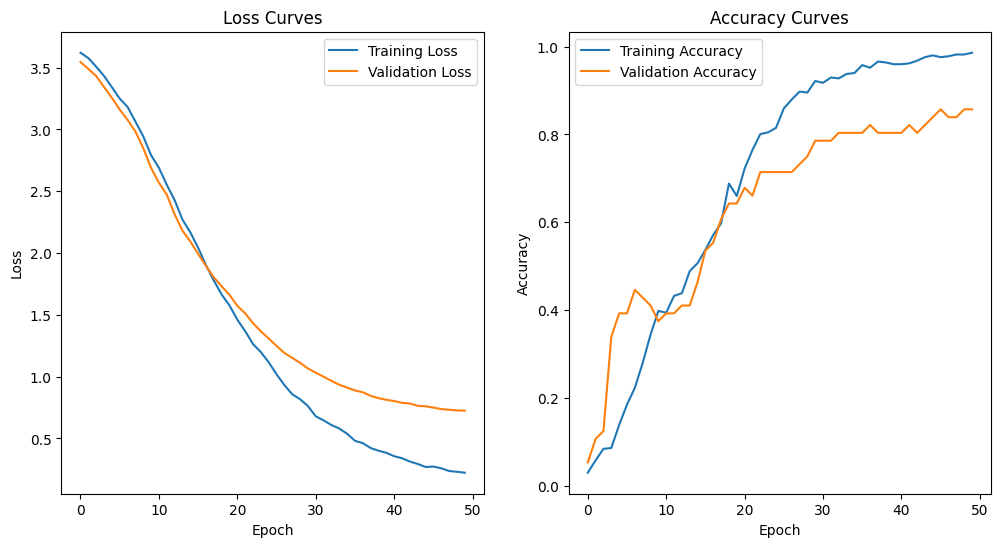

In [31]:
plots_RNN = plot_training_validation_curves(history_RNN, figsize=(12, 6))

In [45]:
test_RNN = model_RNN.evaluate(X_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.6435 - accuracy: 0.8345


## RNN MODEL
### ACCURACY: 98.6%
### VALIDATION ACCURACY: 85.71%
### TEST ACCURACY: 83.45%

In [35]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(500, 100, input_length=X.shape[1]))
model_LSTM.add(SpatialDropout1D(0.2))
model_LSTM.add(LSTM(64, dropout = 0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(36, activation='softmax'))

model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d_3 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 36)                2340      
                                                                 
Total params: 94580 (369.45 KB)
Trainable params: 94580 (369.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history_LSTM = model_LSTM.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size = 64)

Epoch 1/50
8/8 [==============================] - 1s 188ms/step - loss: 3.2494 - accuracy: 0.1730 - val_loss: 3.1783 - val_accuracy: 0.2143
Epoch 2/50
8/8 [==============================] - 2s 199ms/step - loss: 3.1848 - accuracy: 0.1811 - val_loss: 3.1027 - val_accuracy: 0.2143
Epoch 3/50
8/8 [==============================] - 1s 184ms/step - loss: 3.0775 - accuracy: 0.1911 - val_loss: 2.9793 - val_accuracy: 0.2143
Epoch 4/50
8/8 [==============================] - 1s 181ms/step - loss: 2.9352 - accuracy: 0.1911 - val_loss: 2.8529 - val_accuracy: 0.2143
Epoch 5/50
8/8 [==============================] - 2s 190ms/step - loss: 2.7997 - accuracy: 0.2072 - val_loss: 2.7104 - val_accuracy: 0.2321
Epoch 6/50
8/8 [==============================] - 2s 237ms/step - loss: 2.6477 - accuracy: 0.2897 - val_loss: 2.5828 - val_accuracy: 0.3750
Epoch 7/50
8/8 [==============================] - 2s 263ms/step - loss: 2.4907 - accuracy: 0.3662 - val_loss: 2.4734 - val_accuracy: 0.4286
Epoch 8/50
8/8 [====

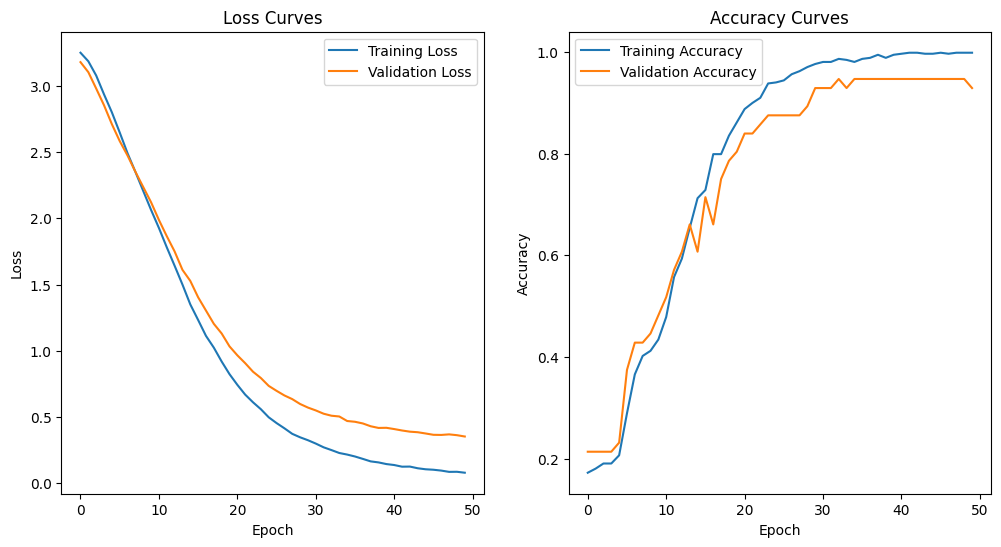

In [38]:
plots_LSTM = plot_training_validation_curves(history_LSTM, figsize=(12, 6))

In [46]:
test_LSTM = model_LSTM.evaluate(X_test, y_test)

5/5 [==============================] - 0s 24ms/step - loss: 0.3955 - accuracy: 0.9137


##LSTM MODEL
### ACCURACY: 99.8%
### VALIDATION ACCURACY: 92.86%
### TEST ACCURACY: 91.37%


In [42]:
model_GRU = Sequential()
model_GRU.add(Embedding(500, 100, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.2))
model_GRU.add(GRU(64, dropout = 0.2, recurrent_dropout=0.2))
model_GRU.add(Dense(36, activation='softmax'))

model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dense_5 (Dense)             (None, 36)                2340      
                                                                 
Total params: 84212 (328.95 KB)
Trainable params: 84212 (328.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size = 64)

Epoch 1/50
8/8 [==============================] - 4s 146ms/step - loss: 3.5681 - accuracy: 0.1328 - val_loss: 3.5366 - val_accuracy: 0.3036
Epoch 2/50
8/8 [==============================] - 1s 90ms/step - loss: 3.5127 - accuracy: 0.2616 - val_loss: 3.4760 - val_accuracy: 0.2679
Epoch 3/50
8/8 [==============================] - 1s 132ms/step - loss: 3.4423 - accuracy: 0.2455 - val_loss: 3.3743 - val_accuracy: 0.2321
Epoch 4/50
8/8 [==============================] - 1s 171ms/step - loss: 3.3171 - accuracy: 0.1891 - val_loss: 3.1574 - val_accuracy: 0.2143
Epoch 5/50
8/8 [==============================] - 1s 174ms/step - loss: 3.1703 - accuracy: 0.1811 - val_loss: 3.0147 - val_accuracy: 0.2143
Epoch 6/50
8/8 [==============================] - 1s 139ms/step - loss: 3.0220 - accuracy: 0.1972 - val_loss: 2.8869 - val_accuracy: 0.2679
Epoch 7/50
8/8 [==============================] - 1s 182ms/step - loss: 2.8466 - accuracy: 0.2636 - val_loss: 2.6717 - val_accuracy: 0.3214
Epoch 8/50
8/8 [=====

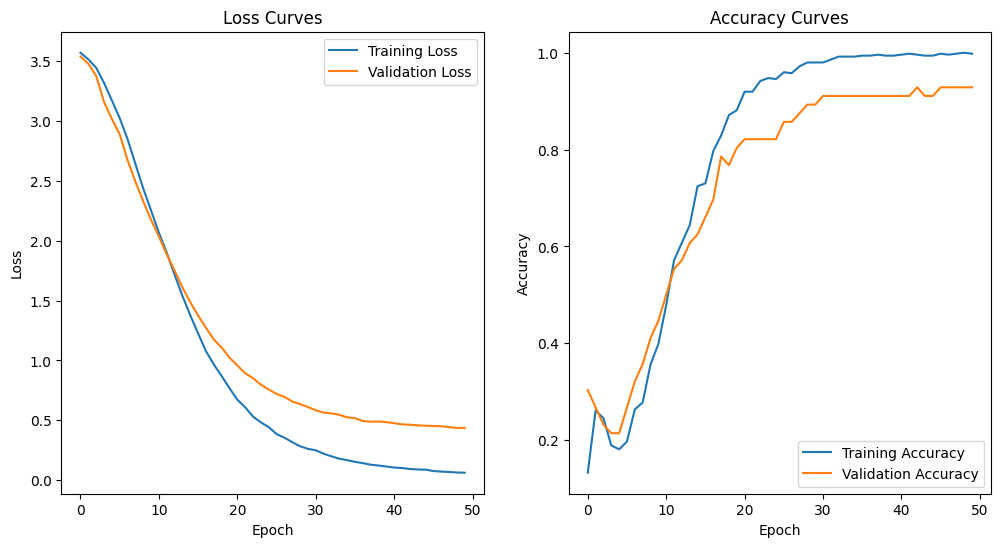

In [44]:
plots_GRU = plot_training_validation_curves(history_GRU, figsize=(12, 6))

In [48]:
test_GRU = model_GRU.evaluate(X_test, y_test)

5/5 [==============================] - 0s 19ms/step - loss: 0.3852 - accuracy: 0.8993


## GRU MODEL
### ACCURACY: 99.8%
### VALIDATION ACCURACY: 92.86%
### TEST ACCURACY: 89.93%

In [50]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(500, 100, input_length=X.shape[1]))
model_BiLSTM.add(SpatialDropout1D(0.2))
model_BiLSTM.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout=0.2)))
model_BiLSTM.add(Dense(36, activation='softmax'))

model_BiLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_BiLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d_6 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense_6 (Dense)             (None, 36)                4644      
                                                                 
Total params: 139124 (543.45 KB)
Trainable params: 139124 (543.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
history_BiLSTM = model_BiLSTM.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size = 64)

Epoch 1/50
8/8 [==============================] - 9s 400ms/step - loss: 3.5626 - accuracy: 0.0704 - val_loss: 3.5159 - val_accuracy: 0.0893
Epoch 2/50
8/8 [==============================] - 2s 288ms/step - loss: 3.4558 - accuracy: 0.1630 - val_loss: 3.3238 - val_accuracy: 0.1786
Epoch 3/50
8/8 [==============================] - 2s 221ms/step - loss: 3.3388 - accuracy: 0.1268 - val_loss: 3.2738 - val_accuracy: 0.1786
Epoch 4/50
8/8 [==============================] - 3s 338ms/step - loss: 3.2711 - accuracy: 0.1569 - val_loss: 3.2458 - val_accuracy: 0.2143
Epoch 5/50
8/8 [==============================] - 3s 410ms/step - loss: 3.2063 - accuracy: 0.1891 - val_loss: 3.1423 - val_accuracy: 0.2143
Epoch 6/50
8/8 [==============================] - 5s 594ms/step - loss: 3.1118 - accuracy: 0.1891 - val_loss: 3.0745 - val_accuracy: 0.2143
Epoch 7/50
8/8 [==============================] - 3s 376ms/step - loss: 2.9741 - accuracy: 0.1851 - val_loss: 2.9354 - val_accuracy: 0.2143
Epoch 8/50
8/8 [====

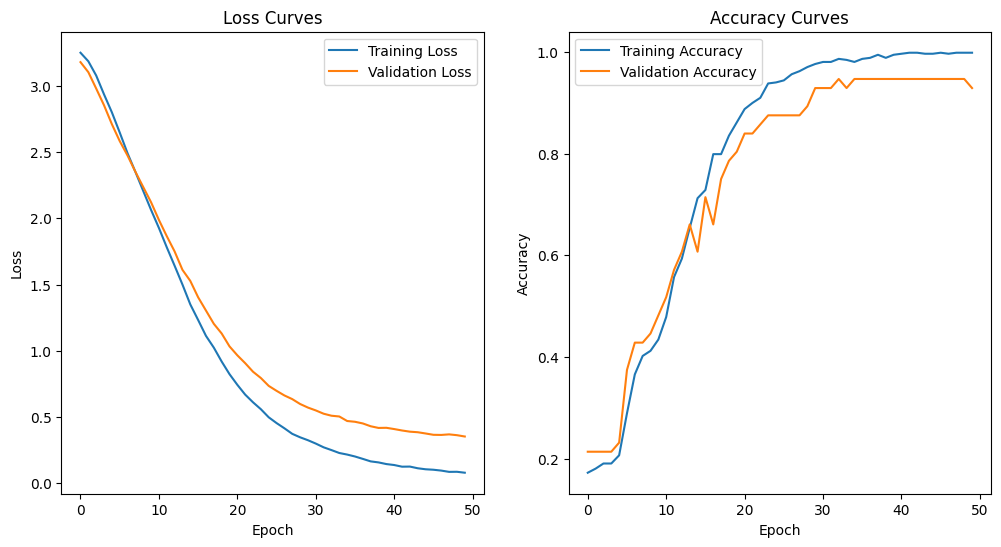

In [52]:
plots_BiLSTM = plot_training_validation_curves(history_BiLSTM, figsize=(12, 6))

In [53]:
test_BiLSTM = model_BiLSTM.evaluate(X_test, y_test)

5/5 [==============================] - 0s 20ms/step - loss: 0.4270 - accuracy: 0.9065


## BiLSTM MODEL
### ACCURACY: 99.8%
### VALIDATION ACCURACY: 92.86%
### TEST ACCURACY: 90.65%

In [54]:
model_CNN = Sequential()
model_CNN.add(Embedding(500, 100, input_length=X.shape[1]))
model_CNN.add(SpatialDropout1D(0.2))
model_CNN.add(Conv1D(64, kernel_size=3))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(36, activation='softmax'))

model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d_7 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            19264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_7 (Dense)             (None, 36)                2340      
                                                                 
Total params: 71604 (279.70 KB)
Trainable params: 7160

In [55]:
history_CNN = model_CNN.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size = 64)

Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 3.5533 - accuracy: 0.0885 - val_loss: 3.5001 - val_accuracy: 0.2143
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 3.4717 - accuracy: 0.2233 - val_loss: 3.4132 - val_accuracy: 0.3036
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 3.3851 - accuracy: 0.2918 - val_loss: 3.3106 - val_accuracy: 0.3571
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 3.2805 - accuracy: 0.2958 - val_loss: 3.1845 - val_accuracy: 0.3750
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 3.1500 - accuracy: 0.2958 - val_loss: 3.0482 - val_accuracy: 0.3929
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 3.0045 - accuracy: 0.2877 - val_loss: 2.9063 - val_accuracy: 0.3750
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 2.8503 - accuracy: 0.2797 - val_loss: 2.7611 - val_accuracy: 0.3214
Epoch 8/50
8/8 [===========

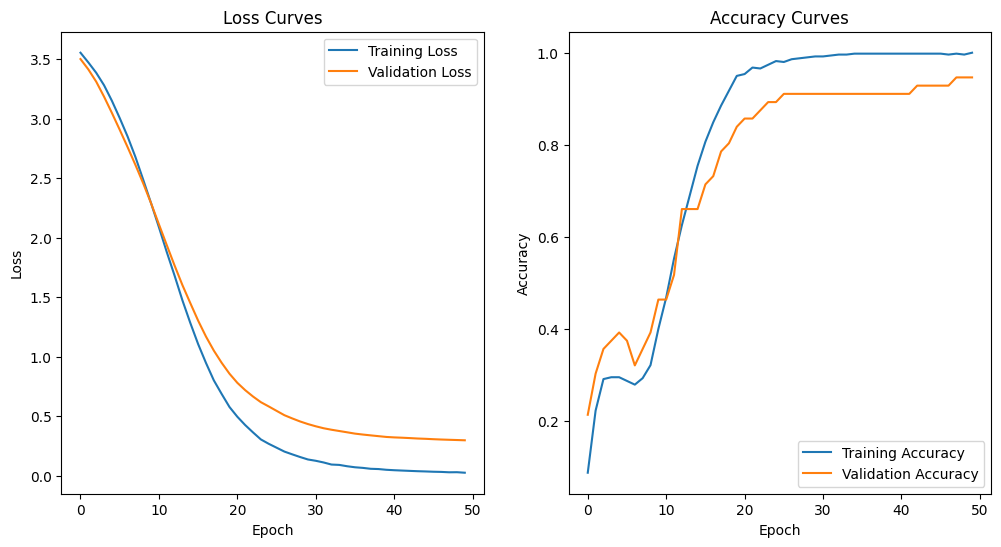

In [56]:
plots_CNN = plot_training_validation_curves(history_CNN, figsize=(12, 6))

In [57]:
test_CNN = model_CNN.evaluate(X_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.4067 - accuracy: 0.9065


## CNN MODEL
### ACCURACY: 99.64%
### VALIDATION ACCURACY: 94.64%
### TEST ACCURACY: 90.65%